# Homework 3 - VAR Model | Zaitsev

## Imports

In [112]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Data

Previously we analysed CO2 Emissions per Capita in Luxembourg, source: https://ourworldindata.org/co2/country/luxembourg

We will directly load first differenced CO2 data.

As an additional series we will use Production: Manufacturing: Total Manufacturing in Luxembourg, source: https://fred.stlouisfed.org/series/PRMNTO01LUQ657S

In [131]:
load_data = True
if load_data:
    data = pd.read_csv("HWIII_data_Zaitsev.csv")
else:
    co2 = pd.read_csv("co2.csv")[["year", "co2_diff"]].rename(mapper={"co2_diff": "co2"}, axis=1)
    co2 = co2[co2["year"] >= 1956].reset_index(drop=True)
    ipi = pd.read_csv("ipi.csv")
    ipi["DATE"] = pd.to_datetime(ipi["DATE"])
    ipi["year"] = ipi["DATE"].dt.year
    ipi = ipi.drop(labels=["DATE"], axis=1).rename(mapper={"PRMNTO01LUQ657S": "ipi"}, axis=1)

    data = co2.merge(ipi, on="year", how="inner")
    data.to_csv("HWIII_data_Zaitsev.csv", index=False)

In [132]:
data.head()

,year,co2,ipi
0,1956,1.390418,1.557415
1,1957,1.344955,-0.805235
2,1958,-2.614837,-0.367406
3,1959,0.867290,2.916800
4,1960,3.287197,0.818914


## Question 1: New Series

Lets plot our series and make it stationary (if not already stationary) for our VAR model.

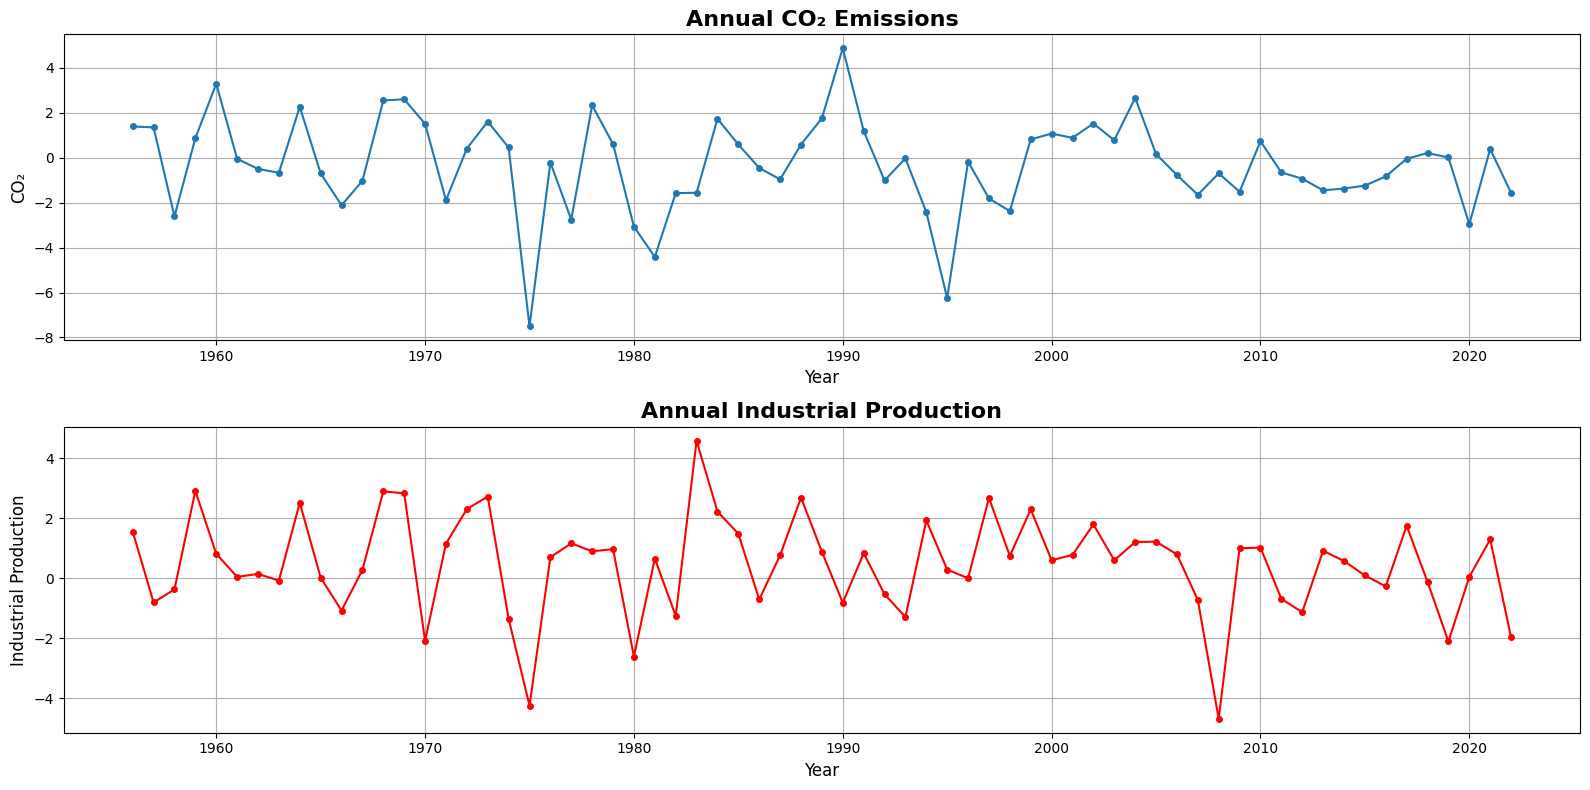

In [163]:
figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

axes[0].plot(data["year"], data["co2"], marker="o", markersize=4, label="CO₂ Emissions")
axes[0].set_title("Annual CO₂ Emissions", fontsize=16, fontweight="bold")
axes[0].set_xlabel("Year", fontsize=12)
axes[0].set_ylabel("CO₂", fontsize=12)
axes[0].grid(True)

axes[1].plot(data["year"], data["ipi"], marker="o", markersize=4, label="Industrial Production", color="red")
axes[1].set_title("Annual Industrial Production", fontsize=16, fontweight="bold")
axes[1].set_xlabel("Year", fontsize=12)
axes[1].set_ylabel("Industrial Production", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

Let's test for stationarity.

In [134]:
stat_tests = pd.DataFrame(np.zeros((2,2)))
stat_tests.index = ["adf", "kpss"]
stat_tests.columns = ["co2", "ipi"]
# tests
for i, col in enumerate(stat_tests.columns):
    adf = round(sm.tsa.stattools.adfuller(data[col], maxlag=5, regression="c", autolag="AIC")[1], 5)
    kpss = round(sm.tsa.stattools.kpss(data[col], regression="c", nlags="auto")[1], 5)
    stat_tests.iloc[0, i] = adf
    stat_tests.iloc[1, i] = kpss
stat_tests

,co2,ipi
adf,0.0,0.0
kpss,0.1,0.1


Using significance level $=0.05$, we deduce:
- `CO2 FIRST DIFFERENCED`: **ADF** **REJECTS** $H_0$ with $\text{p-value}=0.0$, **KPSS** does **NOT REJECT** $H_0$ with $\text{p-value}=0.1$, meaning both tests suggest that the data is `STATIONARY`. 
- `INDUSTRIAL PRODUCTION INDEX, GROWTH RATE`: **ADF** **REJECTS** $H_0$ with $\text{p-value}=0.0$, **KPSS** does **NOT REJECT** $H_0$ with $\text{p-value}=0.1$, meaning both tests suggest that the data is `STATIONARY`. 

The data is ready for the VAR model.

## Question 2: VAR Estimation

First we reserve data for training and forecasting (80% for training).

In [136]:
# select train data
var_data = data[["co2", "ipi"]].reset_index(drop=True)
train_subset_idx = int(len(var_data)*0.8)
var_train = var_data[:train_subset_idx].reset_index(drop=True)

In [137]:
var_train.head()

,co2,ipi
0,1.390418,1.557415
1,1.344955,-0.805235
2,-2.614837,-0.367406
3,0.867290,2.916800
4,3.287197,0.818914


Let's select the best VAR model using `sm.tsa.VAR.select_order()` function, which computes lag order selections based on AIC, BIC, FPE and HQIC.

In [143]:
var_model = sm.tsa.VAR(var_train)
var_lag_selection = var_model.select_order(maxlags=5, trend="c")
var_lag_selection.summary()

,AIC,BIC,FPE,HQIC
0,2.680,2.758*,14.59,2.710*
1,2.682,2.916,14.62,2.771
2,2.594,2.984,13.41,2.742
3,2.735,3.281,15.48,2.941
4,2.823,3.525,16.98,3.088
5,2.528*,3.386,12.74*,2.852


BIC and HQIC suggest to use lag 0, indicating that the changes are largely independent of past values.

In [149]:
# fit the VAR model with lag 1 for both variables
var_results = var_model.fit(maxlags=0, trend="c")
# View the summary
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 23, Nov, 2024
Time:                     14:31:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.70850
Nobs:                     53.0000    HQIC:                   2.66274
Log likelihood:          -218.212    FPE:                    13.9315
AIC:                      2.63415    Det(Omega_mle):         13.4203
--------------------------------------------------------------------
Results for equation co2
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.179052         0.308511           -0.580           0.562

Results for equation ipi
           coefficient       std. error           t-stat            prob
--------------------------------------------------------------------

From the results we deduce:
- `co2 Equation`: The constant term is not significant (p=0.562), indicating no substantial baseline trend for co2 emissions captured by the model.
- `ipi Equation`: The constant term is significant (p=0.016), showing a baseline upward trend for industrial production.
- `Residual Correlation`: A residual correlation of 0.35 implies some unexplained relationship between `co2` and `ipi`.

## Question 3: VAR Forecasts

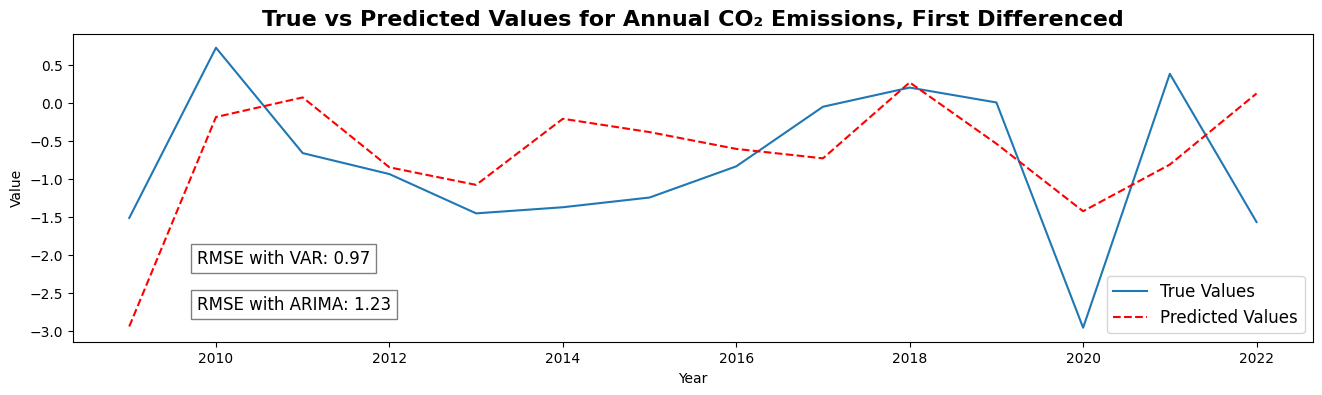

In [161]:
# perform rolling one-step-ahead forecast 
forecasts = []
# loop for 1-step-ahead forecasts on the last 20% of the data
for i in range(train_subset_idx, len(var_data)):
    # get (0, ..., i) data for training
    train_data_i = var_data[:i]
    # declare and fit the VAR model with 1 lag
    var_i = sm.tsa.VAR(train_data_i)
    var_fitted_i = var_i.fit(maxlags=1, trend="c")
    # perform and store forecast
    forecast_i = var_fitted_i.forecast(y=train_data_i.values[-var_fitted_i.k_ar:], steps=1)
    forecasts.append(forecast_i[0])  # append the one-step-ahead forecast

forecasts = np.array(forecasts)
# true values are the last 20% of the data, starting from `train_subset_idx`
true_values = var_data[train_subset_idx:].values
# compute RMSE
rmse = root_mean_squared_error(true_values[:, 0], forecasts[:, 0])
# plot the results
plt.figure(figsize=(16, 4))
plt.plot(data["year"][train_subset_idx:], true_values[:, 0], label="True Values")
plt.plot(data["year"][train_subset_idx:], forecasts[:, 0], label="Predicted Values", color="red", linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Value")
plt.title(f"True vs Predicted Values for Annual CO₂ Emissions, First Differenced", fontsize=16, fontweight="bold")
# add RMSE text to the plot
plt.text(0.1, 0.3, f"RMSE with VAR: {rmse:.2f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))
plt.text(0.1, 0.15, f"RMSE with ARIMA: 1.23", transform=plt.gca().transAxes, fontsize=12, verticalalignment="top", bbox=dict(facecolor="white", alpha=0.5))
plt.legend(fontsize=12)
plt.show()

Suprisingly, the RMSE using VAR model with Industrial Production Index as additional data produces much lower RMSE value. With `ARMA(0,1)` `RMSE=1.23`, now with `VAR(0)` model `RMSE=0.97`. Observing the graph, the predictions also look much nicer: there is not as much "1 year" lags between the predictions and actual values.